# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed and split data from our cache

In [2]:
import pickle


# Label to use for this model in the plots
model_name = 'NN'

with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

# Where we put the intermediate results for this notebook
prefix = 'gasdb_pooled/'

Initialize the CGCNN `net` class

In [3]:
from torch.optim import Adam
import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix=prefix+'valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params(prefix+'valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

# Training

We can train a new model...

In [4]:
net.initialize()
net.fit(sdts_train, targets_train)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.5009        0.6553     +  59.8960
      2        0.4197        0.3540     +  58.5379
      3        0.3834        0.3511     +  58.6165
      4        0.3316        0.3835        58.6248
      5        0.3368        0.3561        58.5757
      6        0.3086        0.3283     +  58.5318
      7        0.3136        0.3199     +  58.5558
      8        0.2805        0.3551        58.5650
      9        0.2957        0.2888     +  58.5911
     10        0.3006        0.2724     +  58.5205
     11        0.2810        0.3039        58.5369
     12        0.2723        0.3038        58.6751
     13        0.2634        0.2776        58.5675
     14        0.2684        0.2763        58.5559
  

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(

In [ ]:
# Restart training in case first round was cut off
net.partial_fit(sdts_train, targets_train)

...or load whatever is cached

In [4]:
net.initialize()
net.load_params(f_history=prefix+'valid_best_history.json',
                f_optimizer=prefix+'valid_best_optimizer.pt', 
                f_params=prefix+'valid_best_params.pt')

# Assess performance
## Validation
We used the results in this section to tune hyperparameters

In [5]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

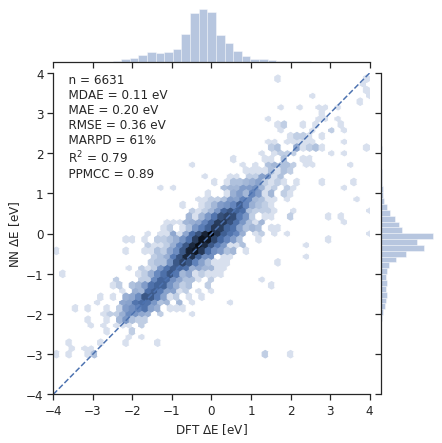

In [8]:
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Make predictions
targets_pred = net.predict(sdts_val).reshape(-1)
residuals = targets_pred - targets_val.reshape(-1)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_val.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred)[0, 1]

# Report
text = ('    n = %i\n' % len(targets_val) +
        '    MDAE = %.2f eV\n' % mdae + 
        '    MAE = %.2f eV\n' % mae + 
        '    RMSE = %.2f eV\n' % rmse + 
        '    MARPD = %i%%\n' % marpd + 
        '    R$^2$ = %.2f\n' % r2 +
        '    PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

## Test
After we finished tuning, we locked parameters and hyperparameters, then report the test results

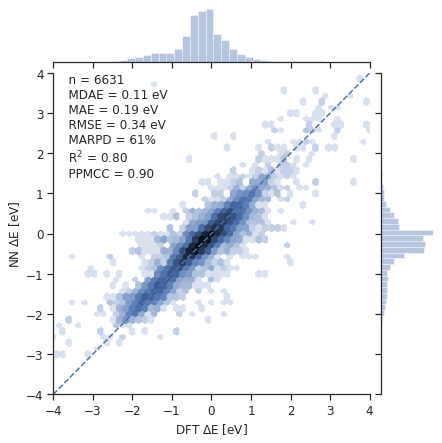

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Make predictions
targets_pred = net.predict(sdts_test).reshape(-1)
residuals = targets_pred - targets_test.reshape(-1)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_test.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_test, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_test, targets_pred))
mdae = median_absolute_error(targets_test, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_test.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_test, targets_pred)
corr = np.corrcoef(targets_test.reshape(-1), targets_pred)[0, 1]

# Report
text = ('    n = %i\n' % len(targets_val) +
        '    MDAE = %.2f eV\n' % mdae + 
        '    MAE = %.2f eV\n' % mae + 
        '    RMSE = %.2f eV\n' % rmse + 
        '    MARPD = %i%%\n' % marpd + 
        '    R$^2$ = %.2f\n' % r2 +
        '    PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

# Save figure
plt.savefig('parity.pdf', dpi=300, bbox_inches='tight', transparent=True)